# Quantifying Data Distortion

Teng-Jui Lin

- Created: 2023-05-28
- Edited: 2024-10-03

In [1]:
from bar_constants import *
from bar_data import *
import bar_util as util
set_save_fig_rc()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Import and Processing

### Bar-level data

In [2]:
X_LABEL = 'True Value'
Y_LABEL = 'Visualized Value'
ALPHA_MARK_LABEL = 'Mark Proportionality Constant'
ALPHA_DIFF_LABEL = 'Difference Proportionality Constant'

In [3]:
value_labels = [VAL_LABEL, VIZ_LABEL]
value_label_labels = [X_LABEL, Y_LABEL]

zero_bar_df_list = []
log_bar_df_list = []
for journal in JOURNALS:
    mistake_zero_bar_df_list = []
    mistake_log_bar_df_list = []
    for mistake in MISTAKES:
        # EXTRACT TRUE AND VISUALIZED VALUES
        for j, value_label in enumerate(value_labels):
            # get filepaths of digitized values in csv
            filepath = os.path.join(MISUSED_BAR_DATA_PATH, journal, mistake)
            filenames = os.listdir(filepath)
            filenames = pd.Series(filenames)
            filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(value_label)]
            filenames = filenames.reset_index(drop=True)
            fignames = filenames.str.slice(stop=-8)
            fig_fullids = fignames.str.replace('fig', '')
            filepaths = filepath + os.sep + filenames
            # read individual csv
            raw_df_dict = {}
            for i, filepath in enumerate(filepaths):
                bar_df_ = pd.read_csv(filepath, header=None, index_col=0)
                bar_df_ = bar_df_.reset_index(drop=True)
                bar_df_.columns = [value_label_labels[j]]
                # # add metadata
                raw_df_dict[fignames[i]] = bar_df_
            
            # construct mistake-level df
            mistake_level_bar_df = pd.concat(raw_df_dict)
            if mistake == ZERO_SUBDIR:
                mistake_zero_bar_df_list.append(mistake_level_bar_df)
            elif mistake == LOG_SUBDIR:
                mistake_log_bar_df_list.append(mistake_level_bar_df)
            else:
                raise ValueError

    # construct journal-level bar df
    # zero
    journal_zero_bar_df = mistake_zero_bar_df_list[0].copy()
    journal_zero_bar_df[Y_LABEL] = mistake_zero_bar_df_list[1][Y_LABEL]
    journal_zero_bar_df[ALPHA_MARK_LABEL] = journal_zero_bar_df[Y_LABEL] / journal_zero_bar_df[X_LABEL]
    zero_bar_df_list.append(journal_zero_bar_df)
    # log
    journal_log_bar_df = mistake_log_bar_df_list[0].copy()
    journal_log_bar_df[Y_LABEL] = mistake_log_bar_df_list[1][Y_LABEL]
    journal_log_bar_df[ALPHA_MARK_LABEL] = journal_log_bar_df[Y_LABEL] / journal_log_bar_df[X_LABEL]
    log_bar_df_list.append(journal_log_bar_df)

# construct overall df
zero_bar_df = pd.concat(zero_bar_df_list)
log_bar_df = pd.concat(log_bar_df_list)
bar_val_df = pd.concat([zero_bar_df, log_bar_df])
bar_val_df

True Value  Visualized Value  \
10.1021:acsnano.3c07517_zero_fig2 0    1.000787          0.200787   
                                  1    1.469291          0.669291   
                                  2    1.264567          0.464567   
10.1021:acsnano.2c10352_zero_fig2 0   20.389610          0.259740   
                                  1   21.255411          0.281385   
...                                         ...               ...   
10.1126:science.ade3483_log_fig1  0  593.139572          0.924386   
                                  1  507.112096          0.901701   
                                  2    7.768894          0.296786   
                                  3    6.061899          0.260870   
                                  4    4.489251          0.217391   

                                     Mark Proportionality Constant  
10.1021:acsnano.3c07517_zero_fig2 0                       0.200629  
                                  1                       0.455520  
                                  2                       0.367372  
10.1021:acsnano.2c10352_zero_fig2 0                       0.012739  
                                  1                       0.013238  
...                                                            ...  
10.1126:science.ade3483_log_fig1  0                       0.001558  
                                  1                       0.001778  
                                  2                       0.038202  
                                  3                       0.043034  
                                  4                       0.048425  

[19827 rows x 3 columns]

In [4]:
bar_val_df.to_csv(bar_val_df_filepath)

### Pairwise permutation-level metric

In [5]:
L_df_list = []
fig_ids = np.unique(bar_val_df.index.get_level_values(0))
for i, fig_id in enumerate(fig_ids):
    df = bar_val_df[bar_val_df.index.get_level_values(0) == fig_id]
    
    # generate permutations and their respective x, y values
    L_df_ = pd.concat(
        [
            util.perm_rel_change(df, X_LABEL), 
            util.perm_rel_change(df, Y_LABEL),
        ], 
        axis=1
    )
    L_df_.columns = ['x_1', 'x_2', 'y_1', 'y_2']

    # store bar id
    L_df_[['Bar 1 ID', 'Bar 2 ID']] = util.perm_rel_change(bar_val_df[bar_val_df.index.get_level_values(0) == fig_id].reset_index(), 'level_1')
    
    # compute lie factor of relative change
    L_df_['E_x_12'] = (L_df_['x_1'] - L_df_['x_2']) / L_df_['x_2']
    L_df_['E_y_12'] = (L_df_['y_1'] - L_df_['y_2']) / L_df_['y_2']
    L_df_['L_12'] = L_df_['E_y_12'] / L_df_['E_x_12']
    L_df_['log L_12'] = np.log10(L_df_['L_12'])

    # compute GDI
    L_df_['GDI_12'] = 100 * (L_df_['L_12'] - 1)

    # compute lie factor of fold change
    L_df_['F_12'] = (L_df_['y_1'] / L_df_['y_2']) / (L_df_['x_1'] / L_df_['x_2'])
    L_df_['log F_12'] = np.log10(L_df_['F_12'])

    # compute RGD
    L_df_['RGD_12'] = L_df_['L_12'] - 1

    # add meta data
    L_df_['Fig Index'] = df.index.get_level_values(0)[0]
    L_df_list.append(L_df_)
L_df = pd.concat(L_df_list, ignore_index=True)
L_df = L_df.set_index('Fig Index')
L_df

,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
Fig Index,,,,,,,,,,,,,,
10.1002:btm2.10487_log_fig1,0.941271,17.800504,0.352212,0.803540,0,1,-0.947121,-0.561674,0.593033,-0.226921,-40.696707,8.289243,0.918515,-0.406967
10.1002:btm2.10487_log_fig1,0.941271,0.297195,0.352212,0.175221,0,2,2.167186,1.010101,0.466089,-0.331531,-53.391128,0.634665,-0.197456,-0.533911
10.1002:btm2.10487_log_fig1,0.941271,3.977009,0.352212,0.573451,0,3,-0.763322,-0.385802,0.505426,-0.296343,-49.457437,2.595076,0.414150,-0.494574
10.1002:btm2.10487_log_fig1,17.800504,0.941271,0.803540,0.352212,1,0,17.911138,1.281407,0.071542,-1.145436,-92.845753,0.120638,-0.918515,-0.928458
10.1002:btm2.10487_log_fig1,17.800504,0.297195,0.803540,0.175221,1,2,58.895093,3.585859,0.060886,-1.215486,-93.911448,0.076565,-1.115971,-0.939114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi9867_log_fig2,1331.015174,786.004146,0.795732,0.742378,2,1,0.693395,0.071869,0.103647,-0.984441,-89.635255,0.632970,-0.198617,-0.896353
10.1126:scitranslmed.adi9867_log_fig2,1331.015174,437.041699,0.795732,0.682927,2,3,2.045511,0.165179,0.080752,-1.092848,-91.924825,0.382589,-0.417268,-0.919248
10.1126:scitranslmed.adi9867_log_fig2,437.041699,2504.337233,0.682927,0.859756,3,0,-0.825486,-0.205674,0.249155,-0.603531,-75.084527,4.551650,0.658169,-0.750845


In [6]:
L_df.to_csv(L_df_filepath)

### Graph-level metric

In [7]:
grouped_alpha = (bar_val_df[ALPHA_MARK_LABEL]).groupby(bar_val_df.index.get_level_values(0))
grouped_alpha_inverse = (1 / bar_val_df[ALPHA_MARK_LABEL]).groupby(bar_val_df.index.get_level_values(0))

In [8]:
cv_df = grouped_alpha.std() / grouped_alpha.mean()
cv_df = cv_df.to_frame()
cv_df.columns = ['CV']
cv_df['log CV'] = np.log10(cv_df['CV'])

cv_df['RCVQ'] = 0.75 * (grouped_alpha.quantile(0.75) - grouped_alpha.quantile(0.25)) / grouped_alpha.median()
cv_df['log RCVQ'] = np.log10(cv_df['RCVQ'])

cv_df['RCVM'] = 1.4826 * grouped_alpha.agg(lambda pop: np.median(np.abs(pop - np.median(pop)))) / grouped_alpha.median()
cv_df['log RCVM'] = np.log10(cv_df['RCVM'])

# tag meta data
cv_df = cv_df.join(bar_annot_df['Mistake'].to_frame())
cv_df

,CV,log CV,RCVQ,log RCVQ,RCVM,log RCVM,Mistake
10.1002:btm2.10487_log_fig1,0.845068,-0.073108,0.892998,-0.049149,0.941095,-0.026366,log
10.1002:btm2.10487_log_fig2,1.048477,0.020559,1.290353,0.110709,1.235633,0.091889,log
10.1002:btm2.10499_zero_fig1,0.457477,-0.339630,0.570541,-0.243713,0.600403,-0.221557,zero
10.1002:btm2.10499_zero_fig2,0.139314,-0.856007,0.137966,-0.860228,0.129917,-0.886333,zero
10.1002:btm2.10499_zero_fig3,0.139831,-0.854397,0.153909,-0.812737,0.110864,-0.955210,zero
...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi7244_zero_fig1,0.198204,-0.702888,0.105113,-0.978342,0.207788,-0.682379,zero
10.1126:scitranslmed.adi7244_zero_fig2,0.701399,-0.154035,0.371973,-0.429488,0.735316,-0.133526,zero
10.1126:scitranslmed.adi7244_zero_fig3,0.468870,-0.328947,0.248656,-0.604401,0.491543,-0.308438,zero
10.1126:scitranslmed.adi9867_log_fig1,0.242860,-0.614644,0.167586,-0.775761,0.182277,-0.739267,log


In [9]:
cv_df.to_csv(cv_df_filepath)

## Data Visualization

### Utility functions

In [10]:
def label_stats(ax, pvalue, gamma, x=0.5, y=0.85, color='k', two_sample=True):
    line_y_offset = 0.03
    line_x_offset = 0.15
    if pvalue < 0.001:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.1e}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
        )
    else:
        ax.text(
            x, 
            y,
            '$\it{P}$ = ' + f'{pvalue:.2}' + '\n$\gamma$ = ' + f'{gamma:.2}',
            ha='center',
            transform=ax.transAxes,
            color=color,
        )
    if two_sample:
        ax.axhline(
            (y - line_y_offset) * ax.get_ylim()[1],
            x - line_x_offset, 
            x + line_x_offset,
            color=color,
            lw=1,
        )

### Metrics vs. mistake types

#### Pairwise-permutation metrics vs. mistake types

n = 747 Zeroing
n = 387 Log
(1134, 18)
Visualization excluded outlier 2/1134 = 0.001763668430335097
n = 747 Zeroing
n = 387 Log
(1134, 18)
Visualization excluded outlier 6/1134 = 0.005291005291005291


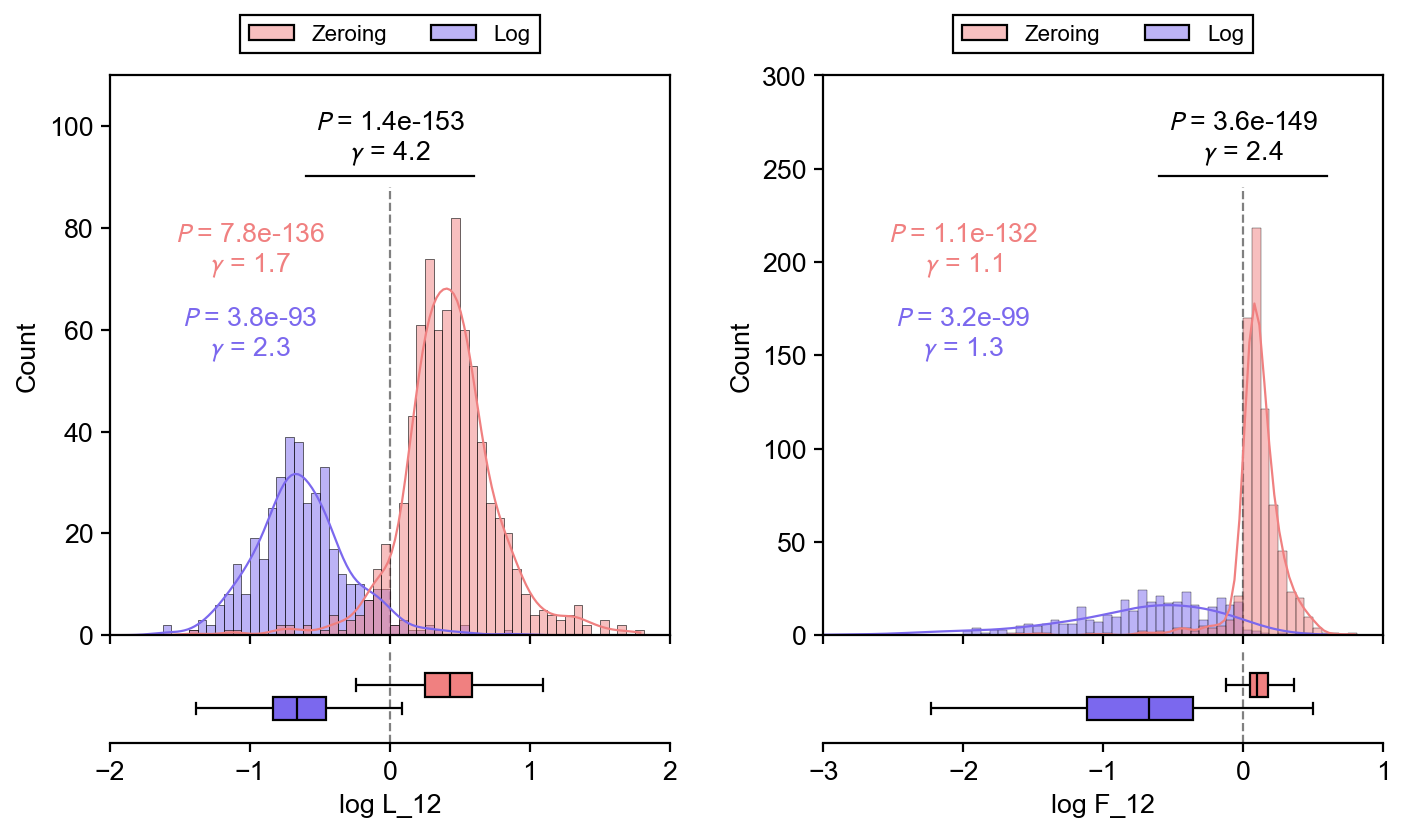

In [11]:
bins = np.arange(-2, 2 + 0.0625, 0.0625)

fig, axs = plt.subplots(2, 2, figsize=(9, 5), height_ratios=[6, 1], sharex='col')
ax_box_rel = axs[1, 0]
ax_hist_rel = axs[0, 0]
ax_box_abs = axs[1, 1]
ax_hist_abs = axs[0, 1]

## subplot 1
property = 'log L_12'
# define visualization domain
xmin = -2
xmax = 2
# eliminate bar-level bias by groupby graphs
plot_df = L_df.groupby(L_df.index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_rel,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_rel,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_xlim(xmin, xmax)
ax_hist_rel.set_ylim(0, 110)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_rel, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

## subplot 2
property = 'log F_12'
# define visualization domain
xmin = -3
xmax = 1
# eliminate bar-level bias by groupby graphs
plot_df = util.keep_finite(L_df)
plot_df = plot_df[plot_df['y_1'] > plot_df['y_2']].groupby(plot_df[plot_df['y_1'] > plot_df['y_2']].index).median()
# tag on text properties
plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Mistake', 'Measurand Level I']])  
# eliminate graph-level bias by groupby physical quantities
plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
# define zero and log conditions
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')

# print info
print(f"n = {sum(zero_cond)} Zeroing")
print(f"n = {sum(log_cond)} Log")
print(plot_df.shape)

excluded_df = plot_df[(
    ((plot_df[property] > xmax) | (plot_df[property] < xmin))
)]
print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")

# visualization
sns.boxplot(
    plot_df,
    x=property,
    hue='Mistake', 
    ax=ax_box_abs,
    width=0.5,
    legend=False,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
hist = sns.histplot(
    plot_df,
    x=property, 
    hue='Mistake', 
    kde=True,
    bins=bins,
    ax=ax_hist_abs,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
)
ax_box_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_xlim(xmin, xmax)
ax_hist_abs.set_ylim(0, 300)

# configure legend
sns.move_legend(
    hist, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

# label two-sample stats
stat, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    plot_df.loc[log_cond, property],
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=0.75,
    y=0.85
)

# label one sample location
one_sample_zero_x = 0.25
one_sample_log_x = one_sample_zero_x
one_sample_zero_y = 0.65
one_sample_y_offset = 0.15
one_sample_log_y = one_sample_zero_y - one_sample_y_offset

# label one-sample stats (zero)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[zero_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[zero_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_zero_x,
    y=one_sample_zero_y,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

# label one-sample stats (log)
pvalue = scipy.stats.quantile_test(
    plot_df.loc[log_cond, property],
).pvalue
gamma = util.get_gamma(
    plot_df.loc[log_cond, property],
    [0]
)
label_stats(
    ax_hist_abs, 
    pvalue, 
    gamma,
    x=one_sample_log_x,
    y=one_sample_log_y,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

# common labels by row and col
for i in range(2):
    axs[0, i].set_box_aspect(1)
    axs[0, i].axvline(0, 0, 0.8, color='gray', lw=1, ls='--', zorder=0)
    
    axs[1, i].set_box_aspect(1/6)
    axs[1, i].axis()
    axs[1, i].spines['left'].set_linewidth(0)
    axs[1, i].spines['right'].set_linewidth(0)
    axs[1, i].spines['top'].set_linewidth(0)
    axs[1, i].tick_params(
        axis='y',
        which='both',
        left=False,
    )
    axs[1, i].axvline(0, 0, 1, color='gray', lw=1, ls='--', zorder=0)

plt.tight_layout(pad=0)

#### Graph-level metrics vs. mistake types

log RCVQ
n = 732 Zeroing
n = 390 Log
(1122, 10)
Visualization excluded outlier 8/1122 = 0.0071301247771836

log RCVM
n = 732 Zeroing
n = 390 Log
(1122, 10)
Visualization excluded outlier 5/1122 = 0.004456327985739751



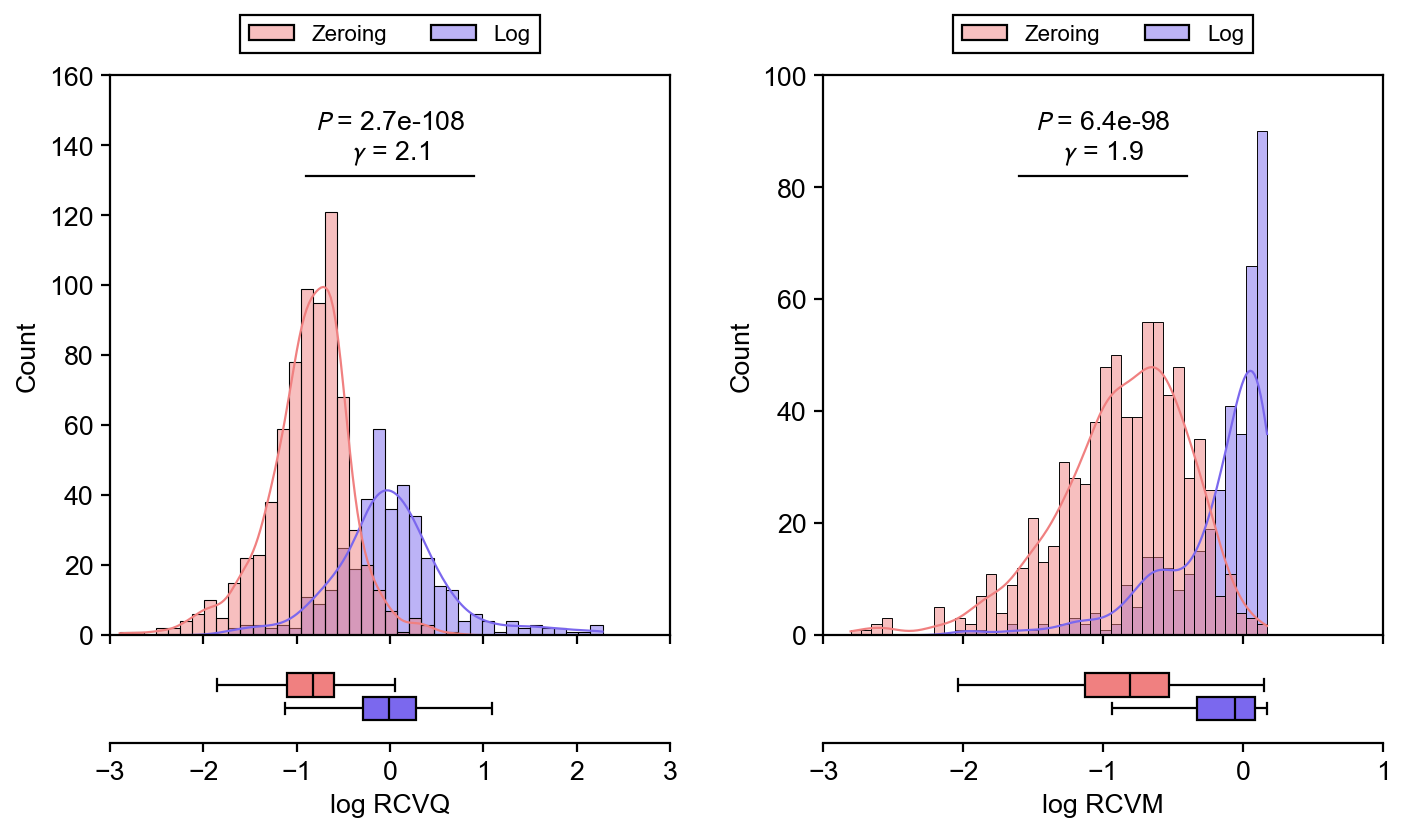

In [12]:
property_list = [
    'RCVQ',
    'RCVM',
]
row = 2
col = len(property_list)
scale = 3
fig, axs = plt.subplots(row, col, figsize=(9, 5), height_ratios=[6, 1], sharex='col')

axs[0, 0].set_ylim(0, 160)
axs[0, 1].set_ylim(0, 100)
axs[0, 0].set_xlim(-3, 3)
axs[0, 1].set_xlim(-3, 1)

for col_i in range(col):
    property = property_list[col_i]
    log_property = f'log {property}'
    #
    xmin, xmax = axs[0, col_i].get_xlim()
    # bins = np.arange(xmin, xmax + 0.0625, 0.0625)
    plot_df = util.keep_finite(cv_df)
    # tag on text properties
    plot_df = plot_df.join(bar_annot_df[['Journal', 'DOI', 'Measurand Level I']])  
    # eliminate graph-level bias by groupby physical quantities
    plot_df = plot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
    plot_df = plot_df.reset_index()
    # define zero and log conditions
    zero_cond = (plot_df['Mistake'] == 'zero')
    log_cond = (plot_df['Mistake'] == 'log')
    # print info
    print(log_property)
    print(f"n = {sum(zero_cond)} Zeroing")
    print(f"n = {sum(log_cond)} Log")
    print(plot_df.shape)
    
    excluded_df = plot_df[(
        ((plot_df[log_property] > xmax) | (plot_df[log_property] < xmin))
    )]
    print(f"Visualization excluded outlier {len(excluded_df)}/{len(plot_df)} = {len(excluded_df)/len(plot_df)}")
    print()
    
    ## first row
    hist = sns.histplot(
        plot_df[
            (plot_df[log_property] >= xmin)
            & (plot_df[log_property] <= xmax)
        ],
        x=log_property,
        hue='Mistake',
        bins=40,
        kde=True,
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        ax=axs[0, col_i],
    )
    # configure legend
    sns.move_legend(
        hist, 
        loc='lower center', 
        **dict(
            bbox_to_anchor=(0.5, 1.02),
            title='',
            labels=[ZERO_LABEL, LOG_LABEL],
            ncol=2,
        )
    )

    # second row
    box = sns.boxplot(
        plot_df,
        x=log_property,
        hue='Mistake',
        hue_order=['zero', 'log'],
        palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
        width=0.5,
        legend=False,
        showfliers=False,
        saturation=1,
        linecolor='k',
        ax=axs[1, col_i],
    )
    
    # label stats
    stat, pvalue = scipy.stats.mannwhitneyu(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    gamma = util.get_gamma(
        plot_df.loc[zero_cond, log_property],
        plot_df.loc[log_cond, log_property],
    )
    label_stats(
        axs[0, col_i], 
        pvalue, 
        gamma,
    )

for col_i in range(col):
    for row_i in range(row):
        axs[0, col_i].set_box_aspect(1)
        axs[1, col_i].set_box_aspect(1/6)
        axs[1, col_i].spines['left'].set_linewidth(0)
        axs[1, col_i].spines['right'].set_linewidth(0)
        axs[1, col_i].spines['top'].set_linewidth(0)
        axs[1, col_i].tick_params(
            axis='y',
            which='both',
            left=False,
        )
plt.tight_layout(pad=0)

### Metrics vs. Measurand, grouped by mistake types

#### Absolute/Relative

(1135, 19)
zero: pvalue = 0.6557194167590146, gamma = 0.033621220800808184
log: pvalue = 1.369382531583344e-06, gamma = 0.5167538703146595
(1135, 19)
zero: pvalue = 0.3444646856258593, gamma = 0.08293704524519904
log: pvalue = 0.1229667577008342, gamma = 0.08250850180511757
(1123, 11)
zero: pvalue = 0.04949673838911666, gamma = 0.17739502282166192
log: pvalue = 0.4809486729261989, gamma = 0.10264776105739458


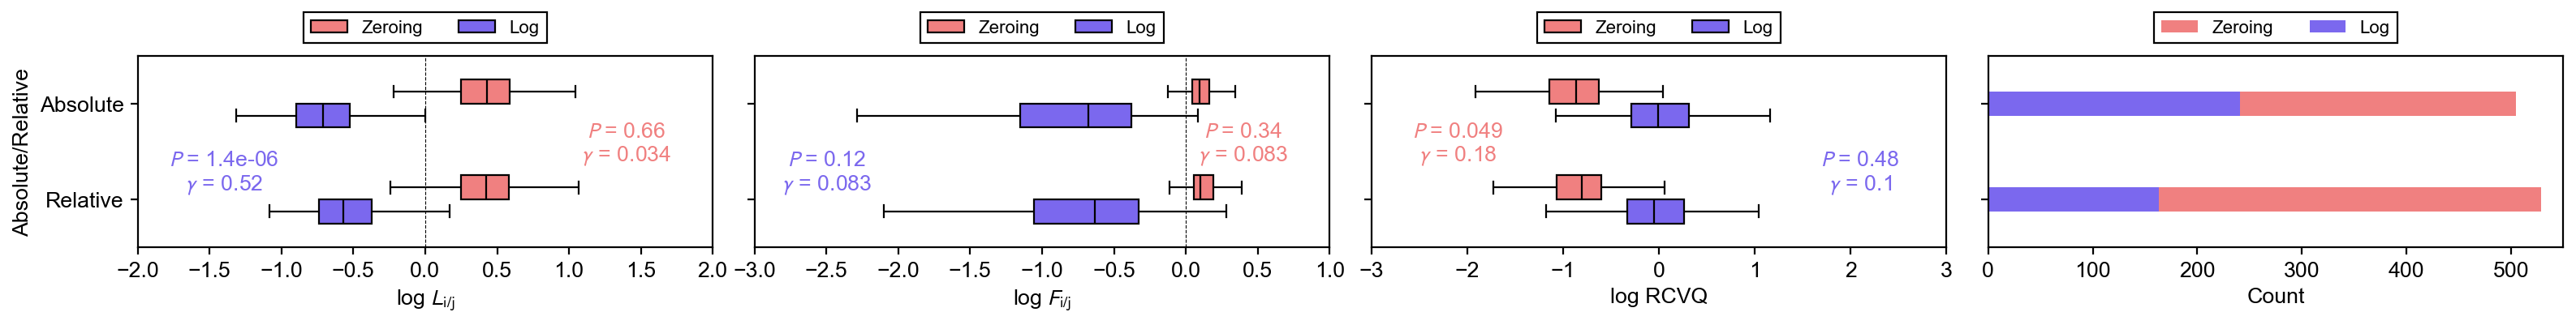

In [13]:
row = 1
col = 4
scale = 3
fig, axs = plt.subplots(row, col, figsize=(20, 5), sharey=True, width_ratios=[1, 1, 1, 1])

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

property = 'log L_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[0], 
    pvalue, 
    gamma,
    x=0.85,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[0], 
    pvalue, 
    gamma,
    x=0.15,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Absolute/Relative',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

property = 'log F_12'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[1], 
    pvalue, 
    gamma,
    x=0.85,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[1], 
    pvalue, 
    gamma,
    x=0.125,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Absolute/Relative',
    hue='Mistake',
    ax=axs[1],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Measurand Level I']])
plot_df = util.keep_finite(plot_df)
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)

property = 'log RCVQ'
zero_cond = (plot_df['Mistake'] == 'zero')
log_cond = (plot_df['Mistake'] == 'log')
abs_cond = (plot_df['Absolute/Relative'] == 'Absolute')
rel_cond = (plot_df['Absolute/Relative'] == 'Relative')
stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[zero_cond & abs_cond, property],
    plot_df.loc[zero_cond & rel_cond, property],
)
print(f'zero: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[2], 
    pvalue, 
    gamma,
    x=0.15,
    y=0.45,
    color=ARTICLES_ZERO_PROBLEM_COLOR,
    two_sample=False,
)

stats, pvalue = scipy.stats.mannwhitneyu(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
gamma = util.get_gamma(
    plot_df.loc[log_cond & abs_cond, property],
    plot_df.loc[log_cond & rel_cond, property],
)
print(f'log: pvalue = {pvalue}, gamma = {gamma}')
label_stats(
    axs[2], 
    pvalue, 
    gamma,
    x=0.85,
    y=0.3,
    color=ARTICLES_LOG_PROBLEM_COLOR,
    two_sample=False,
)

box = sns.boxplot(
    plot_df,
    x=property, 
    y='Absolute/Relative',
    hue='Mistake',
    ax=axs[2],
    width=0.5,
    showfliers=False,
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 4
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.cumsum(axis=1).stack().reset_index(name='Count')
plot_df = df.copy()
# df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
# df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0]
# df.name = 'Count'
# df = df.to_frame().reset_index()
# plot_df = df.copy()
# df = bar_annot_df.groupby(['DOI', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
# df = df.groupby(['Absolute/Relative']).count().iloc[:, 0]
# df.name = 'Count'
# df = df.to_frame().reset_index()
# plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Absolute/Relative',
    hue='Mistake',
    orient='h',
    order=['Absolute', 'Relative'],
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    # palette=['lightgray'],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=axs[3],
)
# configure legend
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 5
# df = bar_annot_df.groupby(['DOI', 'Mistake', 'Absolute/Relative']).count().iloc[:, 0].reset_index()
# df = df.groupby(['Absolute/Relative', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
# df = df.set_index('Absolute/Relative').pivot(columns='Mistake').fillna(0)
# df.columns = df.columns.get_level_values(1)
# df = df.div(df.sum(axis=1), axis=0) * 100
# df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
# plot_df = df.copy()

# bar = sns.barplot(
#     plot_df,
#     x='Percentage',
#     y='Absolute/Relative',
#     hue='Mistake',
#     order=['Absolute', 'Relative'],
#     hue_order=['zero', 'log'],
#     palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
#     dodge=False,
#     saturation=1,
#     width=0.25,
#     ax=axs[4],
# )
# sns.move_legend(
#     bar, 
#     loc='lower center', 
#     **dict(
#         bbox_to_anchor=(0.5, 1.02),
#         title='',
#         labels=[ZERO_LABEL, LOG_LABEL],
#         ncol=2,
#     )
# )

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(4):
    axs[i].set_box_aspect(1/3)

axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-3, 1)
axs[2].set_xlim(-3, 3)
axs[3].set_xlim(0, 550)

axs[0].set_xlabel('log $L_{\mathrm{i/j}}$')
axs[1].set_xlabel('log $F_{\mathrm{i/j}}$')
plt.tight_layout()
fig.savefig(get_figure_filepath(data_distortion_metrics_abs_rel_filename))

#### Measurand Level II

In [14]:
# order by the 5th subplot
# in ascending fraction of zeroing (descending fraction of log)
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Measurand Level II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Measurand Level II', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Measurand Level II').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
order = df.sort_values('zero', ascending=True).index

(1114, 19)
(1114, 19)
(1087, 11)


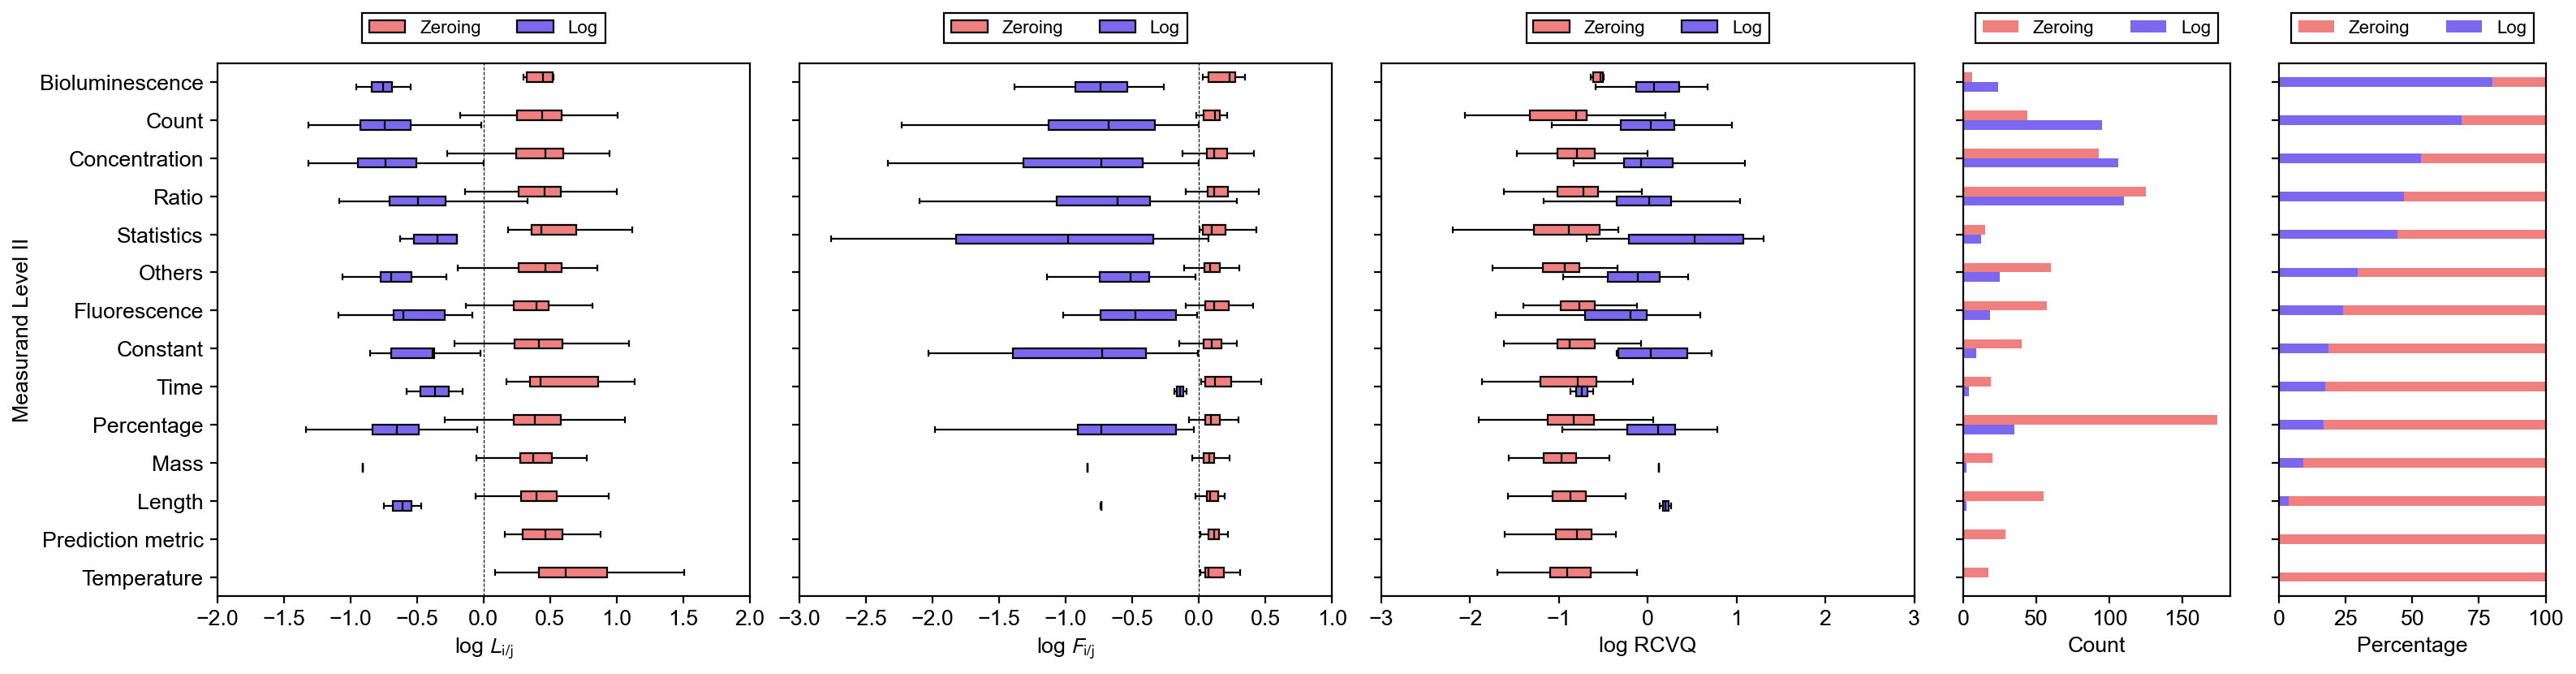

In [15]:
row = 1
col = 5
scale = 3
fig, axs = plt.subplots(row, col, figsize=(20, 5.5), sharey=True, width_ratios=[1, 1, 1, 0.5, 0.5])

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level II']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Measurand Level II',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level II']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Measurand Level II',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Measurand Level II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level II']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log RCVQ', 
    y='Measurand Level II',
    hue='Mistake', 
    ax=axs[2],
    width=0.5,
    legend=True,
    showfliers=False,
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)
# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 4
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Measurand Level II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Measurand Level II', 'Mistake']).count().iloc[:, 0]
df.name = 'Count'
df = df.to_frame().reset_index()
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Measurand Level II',
    hue='Mistake',
    orient='h',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    width=0.5,
    ax=axs[3],
)
# configure legend
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 5
df = bar_annot_df.groupby(['DOI', 'Mistake', 'Measurand Level II']).count().iloc[:, 0].reset_index()
df = df.groupby(['Measurand Level II', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Measurand Level II').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
plot_df = df.copy()

bar = sns.barplot(
    plot_df,
    x='Percentage',
    y='Measurand Level II',
    hue='Mistake',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=axs[4],
)
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(0, 3):
    axs[i].set_box_aspect(1)
for i in range(3, 5):
    axs[i].set_box_aspect(2)

axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-3, 1)
axs[2].set_xlim(-3, 3)
axs[4].set_xlim(0, 100)

axs[0].set_xlabel('log $L_{\mathrm{i/j}}$')
axs[1].set_xlabel('log $F_{\mathrm{i/j}}$')

plt.tight_layout()
fig.savefig(get_figure_filepath(data_distortion_metrics_measurand_ii_filename))
fig.savefig(get_figure_filepath(data_distortion_metrics_measurand_ii_filename, loc=FIG_ARTICLE_SUBPANELS_PATH))

#### Measurand Level I

(1153, 19)
(1153, 19)
(1123, 11)


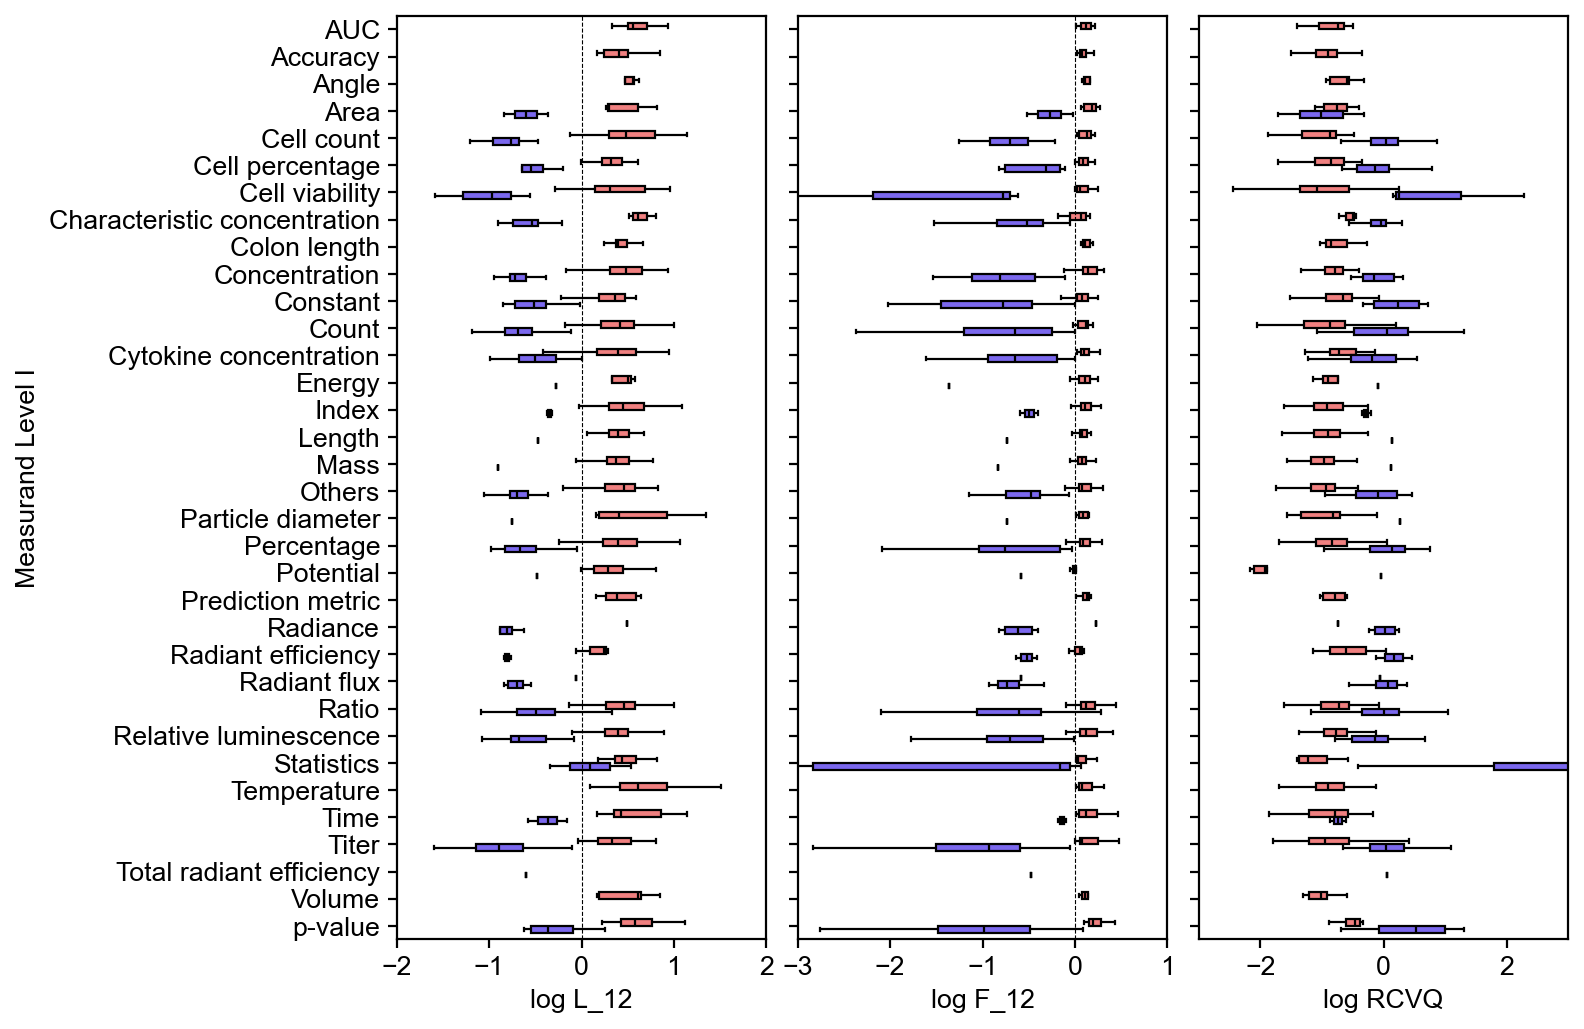

In [16]:
row = 1
col = 3
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 7), sharey=True)

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log L_12',
    y='Measurand Level I',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Measurand Level I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Measurand Level I',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Measurand Level I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Measurand Level I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)
sns.boxplot(
    plot_df,
    x='log RCVQ', 
    y='Measurand Level I',
    hue='Mistake', 
    ax=axs[2],
    width=0.5,
    legend=False,
    showfliers=False,
    order=np.unique(plot_df['Measurand Level I']),
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
)

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(col):
    axs[i].set_box_aspect(2.5)
    
axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-3, 1)
axs[2].set_xlim(-3, 3)
plt.tight_layout()
fig.savefig(get_figure_filepath(data_distortion_metrics_measurand_i_filename))

#### Journal

In [17]:
# order by the 5th subplot
# in ascending fraction of zeroing (descending fraction of log)
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Journal').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
order = df.sort_values('zero', ascending=True).index

(1153, 19)
(1153, 19)
(1123, 11)


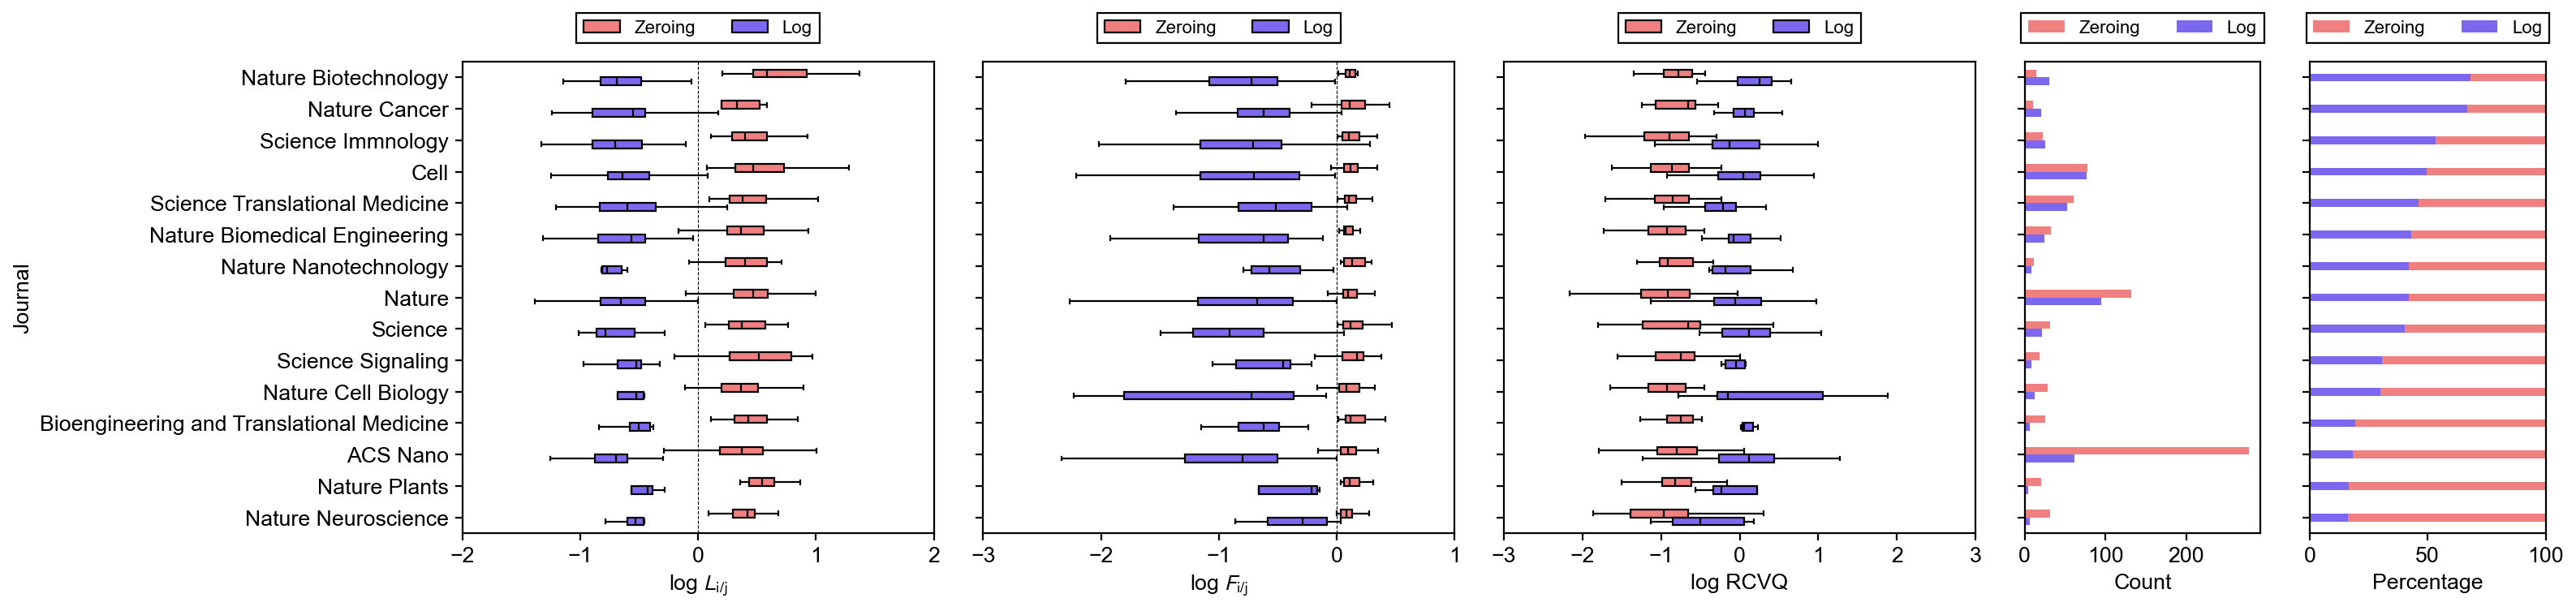

In [18]:
row = 1
col = 5
scale = 3
fig, axs = plt.subplots(row, col, figsize=(20, 5.5), sharey=True, width_ratios=[1, 1, 1, 0.5, 0.5])

## subplot 1
plot_df = L_df.groupby(L_df.index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log L_12',
    y='Journal',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    order=order,
)
axs[0].set_xlim(-2.5, 2.5)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 2
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median().reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log F_12', 
    y='Journal',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    order=order,
)
axs[1].set_xlim(-1, 3)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 3
plot_df = util.keep_finite(cv_df)
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Measurand Level I']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level I']).median()
plot_df = plot_df.reset_index()
print(plot_df.shape)

box = sns.boxplot(
    plot_df,
    x='log RCVQ', 
    y='Journal',
    hue='Mistake', 
    ax=axs[2],
    width=0.5,
    showfliers=False,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    linecolor='k',
    order=order,
)
axs[1].set_xlim(-1, 3)

# configure legend
sns.move_legend(
    box, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 4
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0]
df.name = 'Count'
df = df.to_frame().reset_index()
plot_df = df.copy()

bar = sns.barplot(
    data=plot_df,
    x='Count',
    y='Journal',
    hue='Mistake',
    orient='h',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    saturation=1,
    width=0.5,
    ax=axs[3],
)
# configure legend
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

## subplot 5
df = bar_annot_df.groupby(['Journal', 'DOI', 'Mistake', 'Measurand Level I']).count().iloc[:, 0].reset_index()
df = df.groupby(['Journal', 'Mistake']).count().iloc[:, 0].to_frame().reset_index()
df = df.set_index('Journal').pivot(columns='Mistake').fillna(0)
df.columns = df.columns.get_level_values(1)
df = df.div(df.sum(axis=1), axis=0) * 100
df = df.cumsum(axis=1).stack().reset_index(name='Percentage')
plot_df = df.copy()

bar = sns.barplot(
    plot_df,
    x='Percentage',
    y='Journal',
    hue='Mistake',
    order=order,
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    dodge=False,
    saturation=1,
    width=0.25,
    ax=axs[4],
)
sns.move_legend(
    bar, 
    loc='lower center', 
    **dict(
        bbox_to_anchor=(0.5, 1.02),
        title='',
        labels=[ZERO_LABEL, LOG_LABEL],
        ncol=2,
    )
)

for i in range(2):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
for i in range(0, 3):
    axs[i].set_box_aspect(1)
for i in range(3, 5):
    axs[i].set_box_aspect(2)
    
axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-3, 1)
axs[2].set_xlim(-3, 3)
axs[4].set_xlim(0, 100)

axs[0].set_xlabel('log $L_{\mathrm{i/j}}$')
axs[1].set_xlabel('log $F_{\mathrm{i/j}}$')
axs[0].set_yticklabels([
    'Nature Biotechnology',
    'Nature Cancer',
    'Science Immnology',
    'Cell',
    'Science Translational Medicine',
    'Nature Biomedical Engineering',
    'Nature Nanotechnology',
    'Nature',
    'Science',
    'Science Signaling',
    'Nature Cell Biology',
    'Bioengineering and Translational Medicine',
    'ACS Nano',
    'Nature Plants',
    'Nature Neuroscience',
])

plt.tight_layout()
fig.savefig(get_figure_filepath(data_distortion_metrics_journals_filename))
fig.savefig(get_figure_filepath(data_distortion_metrics_journals_filename, loc=FIG_ARTICLE_SUBPANELS_PATH))

## Correlation between lie factors of relative and fold changes

In [19]:
plot_df = L_df[L_df['x_1'] > L_df['x_2']].groupby(L_df[L_df['x_1'] > L_df['x_2']].index).median()
plot_df = plot_df.join(bar_annot_df[['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level II']])
plot_df = plot_df.groupby(['Absolute/Relative', 'Journal', 'DOI', 'Mistake', 'Measurand Level II']).median().reset_index()
plot_df

,Absolute/Relative,Journal,DOI,Mistake,Measurand Level II,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12
0,Absolute,acs_nano,10.1021:acsnano.2c07436,log,Others,0.000273,0.000225,0.812121,0.783838,3.0,1.00,1.990668,0.202061,0.101507,-0.993505,-89.849276,0.401953,-0.395831,-0.898493
1,Absolute,acs_nano,10.1021:acsnano.2c08153,log,Concentration,12.254337,1.057942,0.892528,0.467438,4.5,4.25,7.610832,1.114541,0.084832,-1.112391,-91.516824,0.221517,-0.691635,-0.915168
2,Absolute,acs_nano,10.1021:acsnano.2c08153,zero,Length,6.701940,0.176367,0.680887,0.049488,4.0,5.00,28.230769,11.468750,0.344828,-0.462398,-65.517241,0.426562,-0.370017,-0.655172
3,Absolute,acs_nano,10.1021:acsnano.2c08240,zero,Concentration,126.888046,125.834915,0.459203,0.388994,3.0,1.00,0.011583,0.274011,21.565854,1.333767,2056.585366,1.259774,0.099242,20.565854
4,Absolute,acs_nano,10.1021:acsnano.2c08434,log,Length,421.147657,8.464510,0.874811,0.309201,5.0,4.00,7.376776,0.614555,0.074540,-1.127610,-92.545996,0.185019,-0.732783,-0.925460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,Relative,science,10.1126:science.adi2246,log,Ratio,1.368317,0.003413,0.856031,0.422179,5.0,10.50,39.881060,0.649846,0.015225,-1.817540,-98.477522,0.043181,-1.364811,-0.984775
1110,Relative,science,10.1126:science.adi4720,zero,Temperature,72.022998,68.937198,0.801533,0.386712,2.5,1.00,0.033757,0.776572,17.524751,1.243470,1652.475136,1.662810,0.220716,16.524751
1111,Relative,science,10.1126:science.adi8885,log,Ratio,1.213554,0.741725,0.083935,-0.234274,0.0,1.00,1.608392,-0.471876,2.514590,0.731242,151.458985,0.558855,0.060626,1.514590
1112,Relative,science,10.1126:science.adi8885,zero,Percentage,76.182553,52.688033,0.769709,0.378134,1.0,0.00,0.418345,1.991251,3.196228,0.439864,219.622776,1.865524,0.219349,2.196228


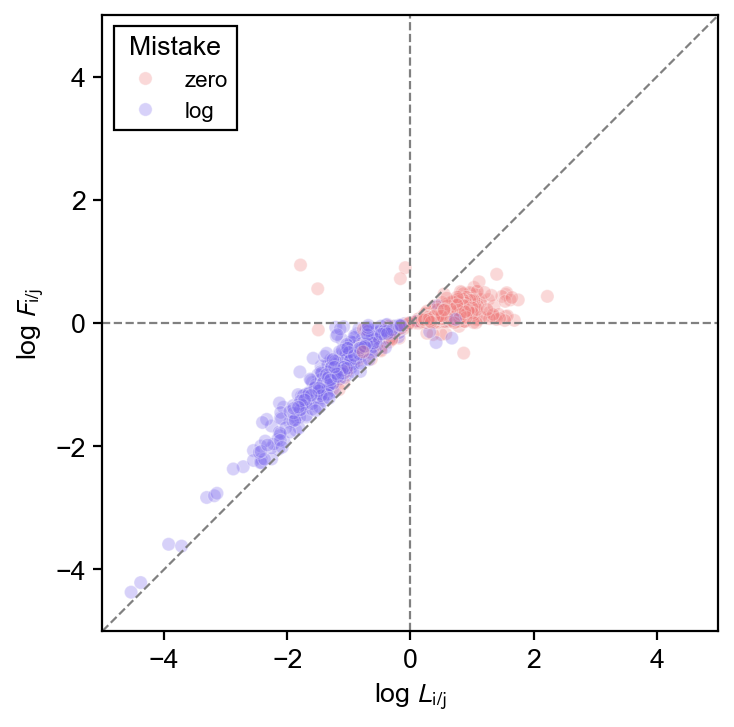

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    plot_df,
    x='log L_12',
    y='log F_12',
    hue='Mistake',
    hue_order=['zero', 'log'],
    palette=[ARTICLES_ZERO_PROBLEM_COLOR, ARTICLES_LOG_PROBLEM_COLOR],
    alpha=0.3,
    # s=10,
    ax=ax,
)
ax.plot([-5, 5], [-5, 5], '--', color='gray')
ax.plot([-5, 5], [0, 0], '--', color='gray')
ax.plot([0, 0], [-5, 5], '--', color='gray')
ax.set_box_aspect(1)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_xlabel('log $L_{\mathrm{i/j}}$')
ax.set_ylabel('log $F_{\mathrm{i/j}}$')
fig.savefig(get_figure_filepath(lie_factor_correlation_filename))
fig.savefig(get_figure_filepath(lie_factor_correlation_filename, loc=FIG_ARTICLE_SUBPANELS_PATH))

## Sankey relation diagram for measurand annotations

In [21]:
base = 0
label_dict_1 = tuple(zip(bar_annot_df['Absolute/Relative'].unique(), np.arange(base, base + len(bar_annot_df['Absolute/Relative'].unique())+1)))
label_dict_1

(('Relative', 0), ('Absolute', 1))

In [22]:
base = 2
label_dict_2 = tuple(zip(bar_annot_df['Measurement Type'].unique(), np.arange(base, base + len(bar_annot_df['Measurement Type'].unique())+1)))
label_dict_2

(('Measured value', 2),
 ('Percentage', 3),
 ('Calculated value', 4),
 ('Ratio', 5))

In [23]:
base = 6
label_dict_3 = tuple(zip(bar_annot_df['Measurand Level II'].unique(), np.arange(base, base + len(bar_annot_df['Measurand Level II'].unique())+1)))
# label_dict_3

In [24]:
base = 20
label_dict_4 = tuple(zip(bar_annot_df['Measurand Level I'].unique(), np.arange(base, base + len(bar_annot_df['Measurand Level I'].unique())+1)))
# label_dict_4

In [25]:
label_dict = (label_dict_1 + label_dict_2 + label_dict_3 + label_dict_4)

In [26]:
sankey_data_list = []

In [27]:
df = bar_annot_df.groupby(['Absolute/Relative', 'Measurement Type']).count().iloc[:, 0].reset_index()
for label, index in label_dict_1:
    df.loc[df['Absolute/Relative'] == label, 'Absolute/Relative'] = index
for label, index in label_dict_2:
    df.loc[df['Measurement Type'] == label, 'Measurement Type'] = index
sankey_data_list.append(df.values.T)

In [28]:
df = bar_annot_df.groupby(['Measurement Type', 'Measurand Level II']).count().iloc[:, 0].reset_index()
for label, index in label_dict_2:
    df.loc[df['Measurement Type'] == label, 'Measurement Type'] = index
for label, index in label_dict_3:
    df.loc[df['Measurand Level II'] == label, 'Measurand Level II'] = index
sankey_data_list.append(df.values.T)

In [29]:
df = bar_annot_df.groupby(['Measurand Level II', 'Measurand Level I']).count().iloc[:, 0].reset_index()
for label, index in label_dict_3:
    df.loc[df['Measurand Level II'] == label, 'Measurand Level II'] = index
for label, index in label_dict_4:
    df.loc[df['Measurand Level I'] == label, 'Measurand Level I'] = index
sankey_data_list.append(df.values.T)

In [30]:
sankey_data = np.hstack(sankey_data_list)
sankey_data

array([[1, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 5, 5, 5, 19, 19, 19, 19, 10, 10, 10, 10, 15, 15, 17, 17,
        8, 8, 8, 8, 9, 9, 9, 13, 11, 11, 11, 11, 11, 11, 7, 7, 7, 18, 18,
        18, 12, 14, 14, 6, 16],
       [2, 4, 2, 3, 5, 19, 10, 15, 8, 11, 18, 12, 19, 10, 15, 17, 8, 9,
        13, 11, 18, 14, 6, 16, 7, 19, 8, 12, 39, 38, 52, 22, 51, 24, 26,
        25, 36, 40, 43, 44, 39, 38, 22, 53, 41, 23, 35, 29, 49, 27, 45,
        32, 37, 46, 30, 31, 21, 48, 47, 50, 28, 34, 33, 20, 42],
       [1743, 489, 59, 520, 766, 58, 1, 43, 149, 7, 217, 14, 28, 771, 50,
        474, 16, 102, 54, 156, 1, 48, 45, 57, 520, 4, 7, 755, 5, 2, 21,
        62, 84, 130, 111, 447, 50, 43, 199, 275, 3, 8, 157, 4, 31, 54,
        17, 54, 11, 17, 10, 90, 14, 21, 127, 35, 358, 108, 59, 51, 769,
        13, 35, 45, 57]], dtype=object)

In [31]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = np.array(label_dict)[:, 0],
        color = "blue"
    ),
    link = dict(
        source = sankey_data[0], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = sankey_data[1],
        value = sankey_data[2],
    )
)],)

fig.update_layout(title_text="Basic Sankey Diagram", font_size=16, width=1500, height=1200)
fig.show()

## Difference proportionality constants

In [32]:
L_df_prime = L_df[L_df.index.str.contains('zero')]
alpha_12 = (L_df_prime['y_1'] - L_df_prime['y_2']) / (L_df_prime['x_1'] - L_df_prime['x_2'])
alpha_12.groupby(alpha_12.index).std() / alpha_12.groupby(alpha_12.index).mean()

Fig Index
10.1002:btm2.10499_zero_fig1              7.868106e-16
10.1002:btm2.10499_zero_fig2              2.337345e-15
10.1002:btm2.10499_zero_fig3              1.367748e-14
10.1002:btm2.10499_zero_fig4              1.634156e-15
10.1002:btm2.10499_zero_fig5              4.023114e-15
                                              ...     
10.1126:scitranslmed.adh0908_zero_fig3    1.331127e-14
10.1126:scitranslmed.adh7668_zero_fig1    3.506872e-15
10.1126:scitranslmed.adi7244_zero_fig1    0.000000e+00
10.1126:scitranslmed.adi7244_zero_fig2    0.000000e+00
10.1126:scitranslmed.adi7244_zero_fig3    0.000000e+00
Length: 1937, dtype: float64

In [33]:
util.keep_finite(grouped_alpha.median()[grouped_alpha.median().index.str.contains('zero')] / alpha_12.groupby(alpha_12.index).mean())

10.1002:btm2.10499_zero_fig1              0.219757
10.1002:btm2.10499_zero_fig2              0.717588
10.1002:btm2.10499_zero_fig3              0.621585
10.1002:btm2.10499_zero_fig4              0.649518
10.1002:btm2.10499_zero_fig5              0.680352
                                            ...   
10.1126:scitranslmed.adh0908_zero_fig3    0.151049
10.1126:scitranslmed.adh7668_zero_fig1    0.618326
10.1126:scitranslmed.adi7244_zero_fig1    0.372413
10.1126:scitranslmed.adi7244_zero_fig2    0.049114
10.1126:scitranslmed.adi7244_zero_fig3    0.263675
Length: 1932, dtype: float64

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   3.,
          9.,   8.,  17.,  21.,  49.,  49.,  94., 153., 267., 315., 318.,
        316.,  94., 114.,  40.,   9.,   7.,   6.,   4.,   4.,   1.,   1.,
          0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.]),
 array([-3.   , -2.875, -2.75 , -2.625, -2.5  , -2.375, -2.25 , -2.125,
        -2.   , -1.875, -1.75 , -1.625, -1.5  , -1.375, -1.25 , -1.125,
        -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
         0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
         1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
         2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875]),
 <BarContainer object of 47 artists>)

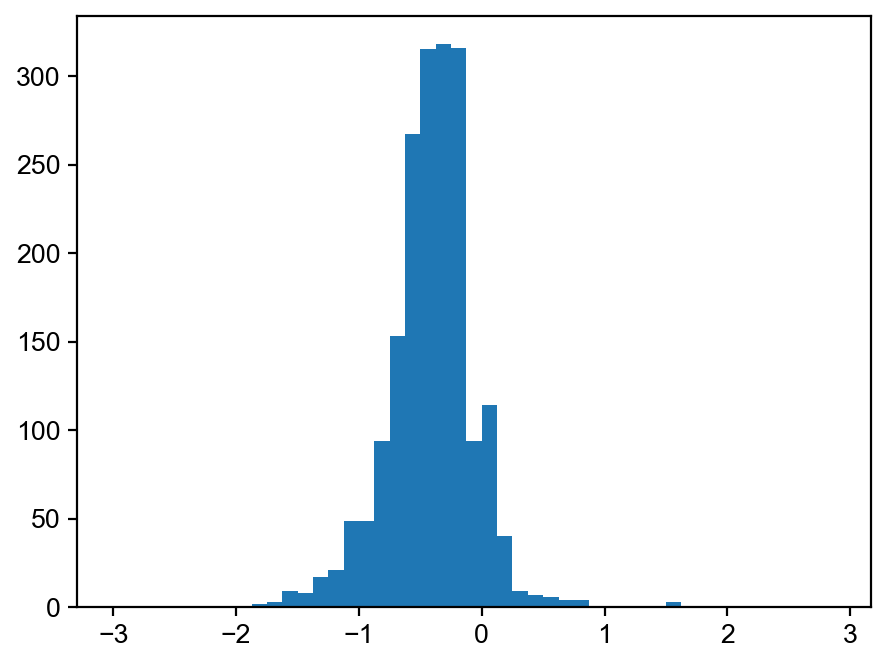

In [34]:
plt.hist(
    np.log10(util.keep_finite(grouped_alpha.median()[grouped_alpha.median().index.str.contains('zero')] / alpha_12.groupby(alpha_12.index).mean())),
    bins=np.arange(-3, 3, 0.25/2),
)